In [1]:
#Setting up the Environment
import torch
import torchvision

In [2]:
#Preparing the dataset
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [3]:
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('/files/', train=True, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307, ), (0.3081, ))
                               ])),
    batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('/files/', train=False, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307, ), (0.3081, ))
                               ])),
    batch_size=batch_size_test, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 98962691.75it/s]


Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 63755628.33it/s]


Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 30787650.01it/s]


Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13406424.19it/s]


Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw



In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [5]:
example_data.shape

torch.Size([1000, 1, 28, 28])

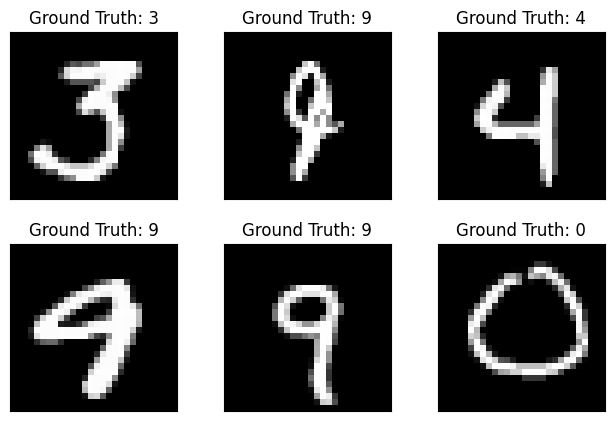

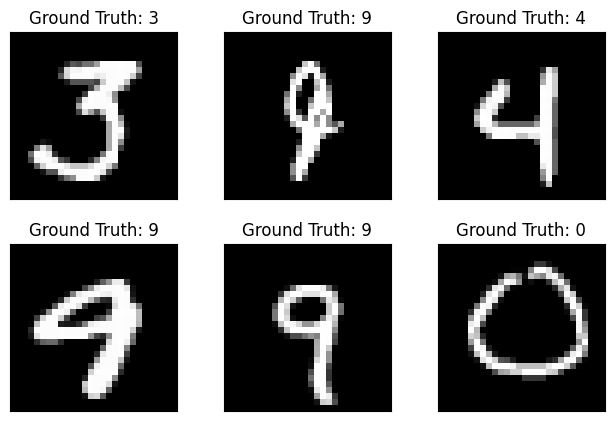

In [6]:
import matplotlib.pyplot as plt
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [7]:
#Building the Network
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [8]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
    self.conv2_drop = nn.Dropout2d()
    self.fc1 = nn.Linear(320, 50)
    self.fc2 = nn.Linear(50, 10)

  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
    x = x.view(-1, 320)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, training=self.training)
    x = self.fc2(x)
    return F.log_softmax(x)

In [9]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

In [10]:
#Training the Model
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [11]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. *batch_idx/len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
          (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), '/content/model.pth')
      torch.save(optimizer.state_dict(), '/content/optimizer.pth')

In [12]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [13]:
test()
for epoch in range (1, n_epochs + 1):
  train(epoch)
  test()

<ipython-input-8-0dee77dbc79b>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3096, Accuracy: 924/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.313179
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.300776
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.298872
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.276723
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.241102
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.248662
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.189547
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.146399
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.107701
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.011356
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.843857
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.758839
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.672644
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.687645
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.426628
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.284204
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.318824
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.445287
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.140658
Train Epoch: 1 [12160/6

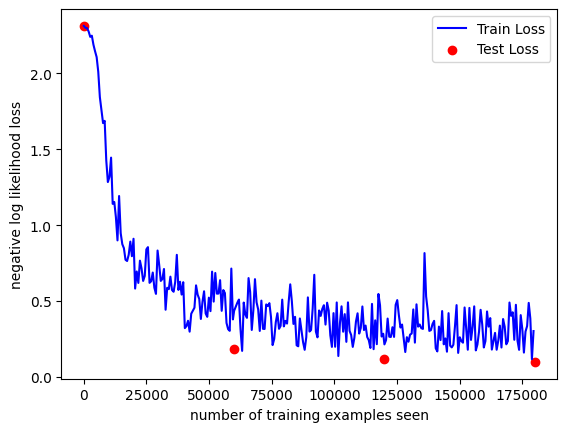

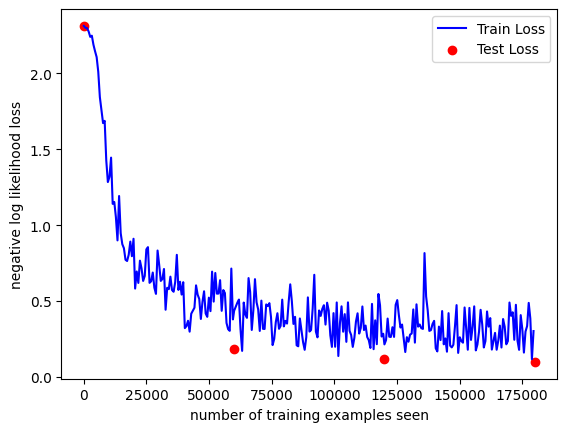

In [14]:
#Evaluating the Model's Performance
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color = 'red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

In [15]:
with torch.no_grad():
  output = network(example_data)

<ipython-input-8-0dee77dbc79b>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


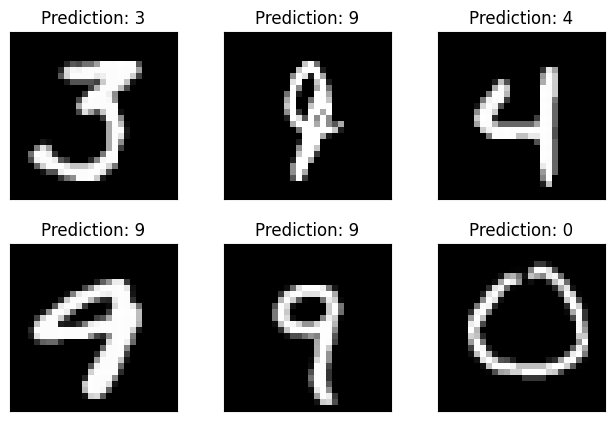

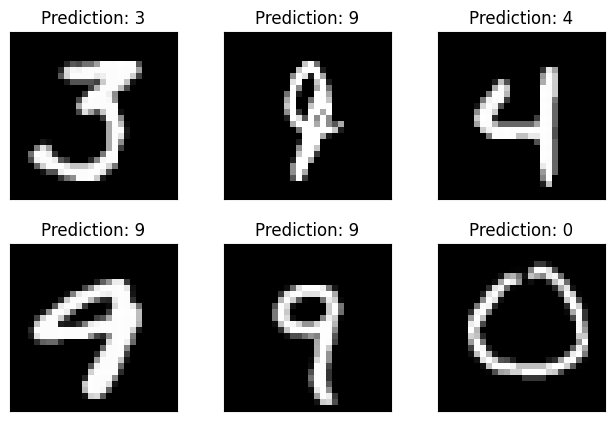

In [16]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
      output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

In [17]:
#Continued Training from Checkpoints
continued_network = Net()
continued_optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

In [18]:
network_state_dict = torch.load('/content/model.pth')
continued_network.load_state_dict(network_state_dict)

optimizer_state_dict = torch.load('/content/optimizer.pth')
continued_optimizer.load_state_dict(optimizer_state_dict)

In [19]:
for i in range(4,9):
  test_counter.append(i*len(train_loader.dataset))
  train(i)
  test()

<ipython-input-8-0dee77dbc79b>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 4 [0/60000 (0%)]	Loss: 0.208578
Train Epoch: 4 [640/60000 (1%)]	Loss: 0.362787
Train Epoch: 4 [1280/60000 (2%)]	Loss: 0.333615
Train Epoch: 4 [1920/60000 (3%)]	Loss: 0.426016
Train Epoch: 4 [2560/60000 (4%)]	Loss: 0.480444
Train Epoch: 4 [3200/60000 (5%)]	Loss: 0.132955
Train Epoch: 4 [3840/60000 (6%)]	Loss: 0.287925
Train Epoch: 4 [4480/60000 (7%)]	Loss: 0.335721
Train Epoch: 4 [5120/60000 (9%)]	Loss: 0.147954
Train Epoch: 4 [5760/60000 (10%)]	Loss: 0.196418
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.154988
Train Epoch: 4 [7040/60000 (12%)]	Loss: 0.164102
Train Epoch: 4 [7680/60000 (13%)]	Loss: 0.217753
Train Epoch: 4 [8320/60000 (14%)]	Loss: 0.395624
Train Epoch: 4 [8960/60000 (15%)]	Loss: 0.450458
Train Epoch: 4 [9600/60000 (16%)]	Loss: 0.152898
Train Epoch: 4 [10240/60000 (17%)]	Loss: 0.150686
Train Epoch: 4 [10880/60000 (18%)]	Loss: 0.467977
Train Epoch: 4 [11520/60000 (19%)]	Loss: 0.139718
Train Epoch: 4 [12160/60000 (20%)]	Loss: 0.232057
Train Epoch: 4 [12800/60000 (

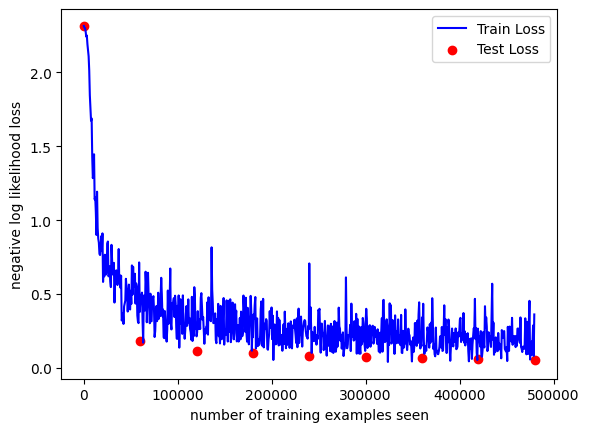

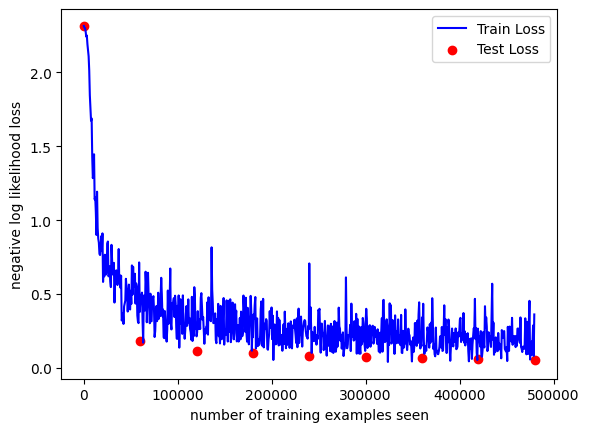

In [20]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

In [33]:
import cv2
import torch
import torchvision.transforms as transforms
import tensorflow as tf
import torchvision.transforms.functional as fn
import numpy as np
from numpy import argmax

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

#load and prepare the image
def load_image(filename):
  img = cv2.imread('/content/' + filename + '.jpg')
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.resize(img, (28,28))
  transform = transforms.ToTensor()
  img = transform(img)
  img = torch.unsqueeze(img, dim=0)
#  img = tf.cast(img, dtype = tf.float32)
  img = img - 0.1307
  img = img/0.3081
#  img = tf.Variable(img)
#  img = img.detach().numpy()         #convert EagerTensor to numpy
#  img = torch.from_numpy(img)        #convert numpy to tensor

#  img = fn.resize(img, size=[24])
#  img = np.reshape(img,(28,28))
#  img = img.astype('float32')
#  img = img/255.0
  return img
img = load_image('8')

print(type(img))
print(tf.shape(img))

<class 'torch.Tensor'>
tf.Tensor([ 1  1 28 28], shape=(4,), dtype=int32)


In [35]:
import torch
import torchvision.models as models
from torch import optim
#load an image and predict the class
def run_example(filename):
  #load the image
  img = load_image(filename)
  #load the model
  network.load_state_dict(torch.load('/content/model.pth'))
  #predict the class
  def predict(tensor, model):
    yhat = model(tensor)
    yhat = yhat.clone().detach()
    return yhat
  predict_value = predict(img, network)
  digit = argmax(predict_value)
  print(digit)
run_example('8')

tensor(8)


<ipython-input-8-0dee77dbc79b>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
